[OK] Loaded all conditions.


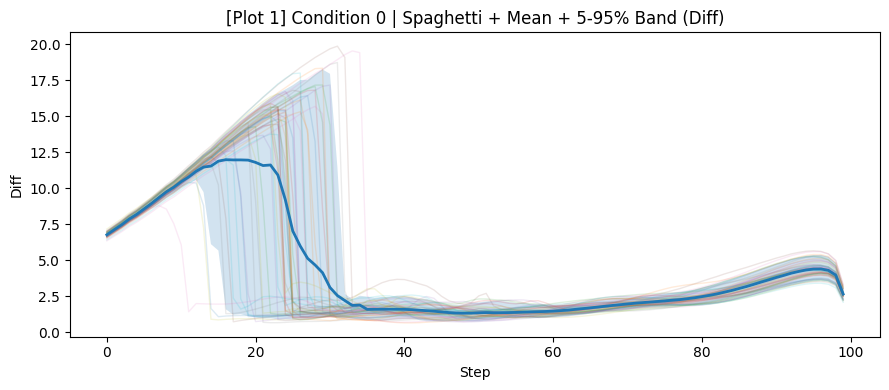

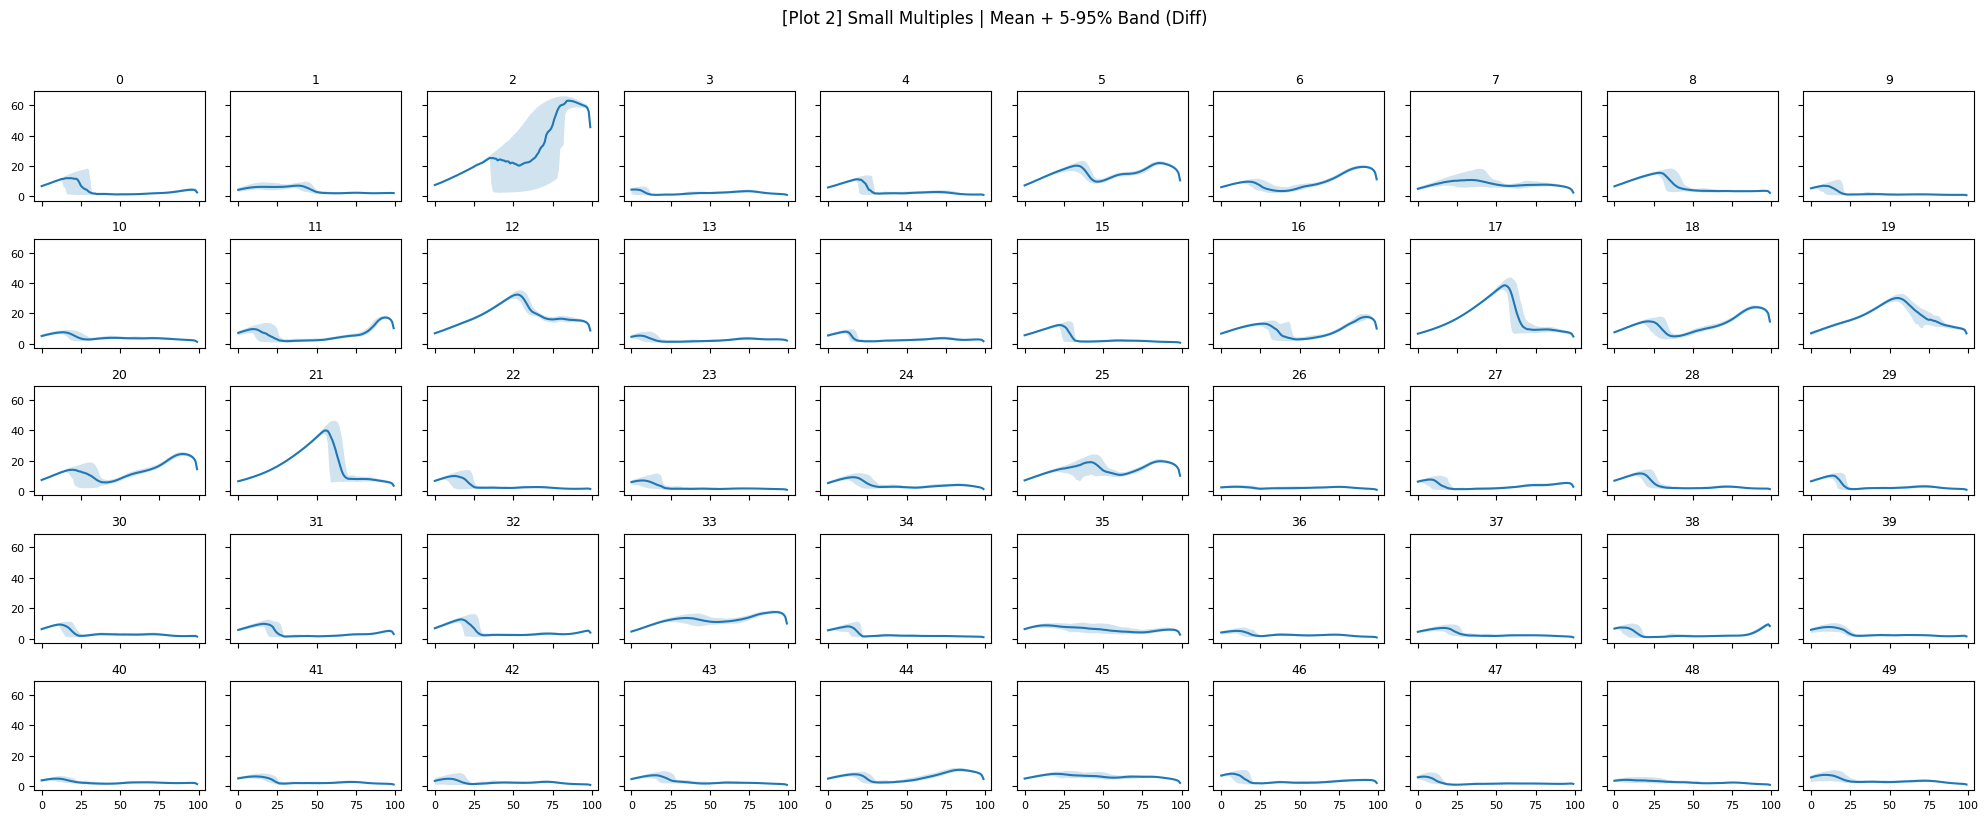

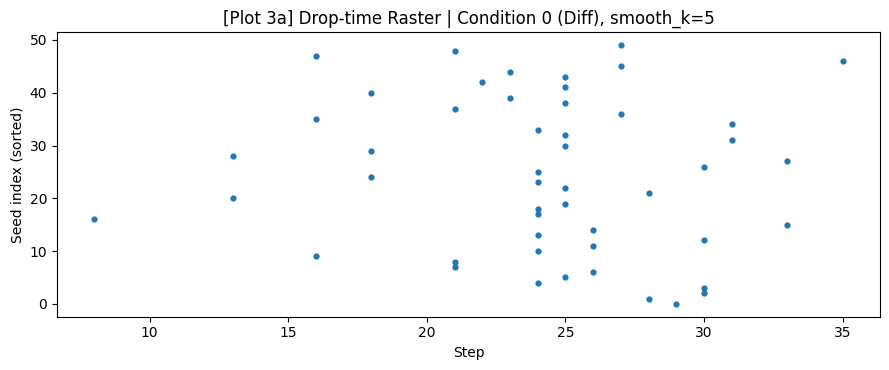

/tmp/ipykernel_793769/3014937865.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)


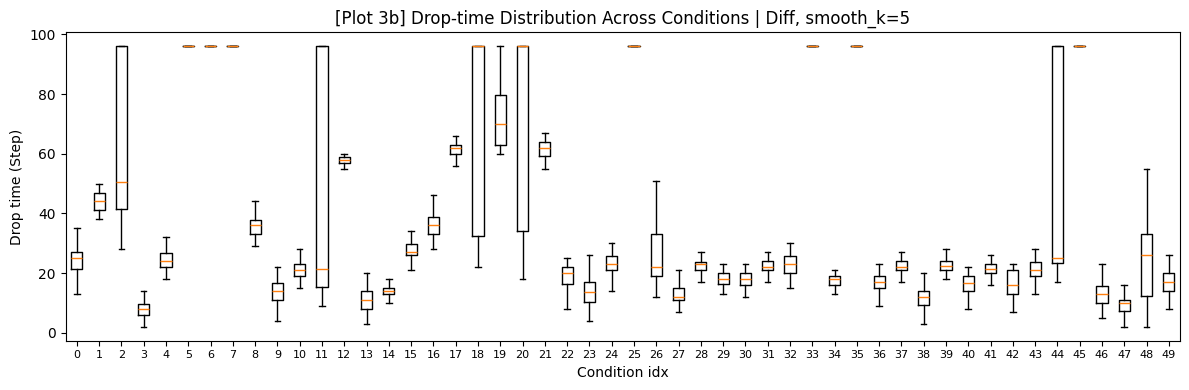

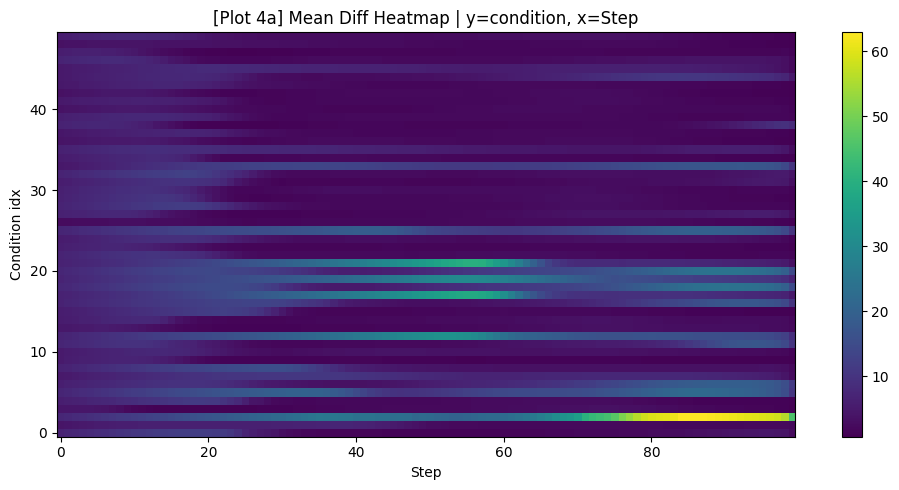

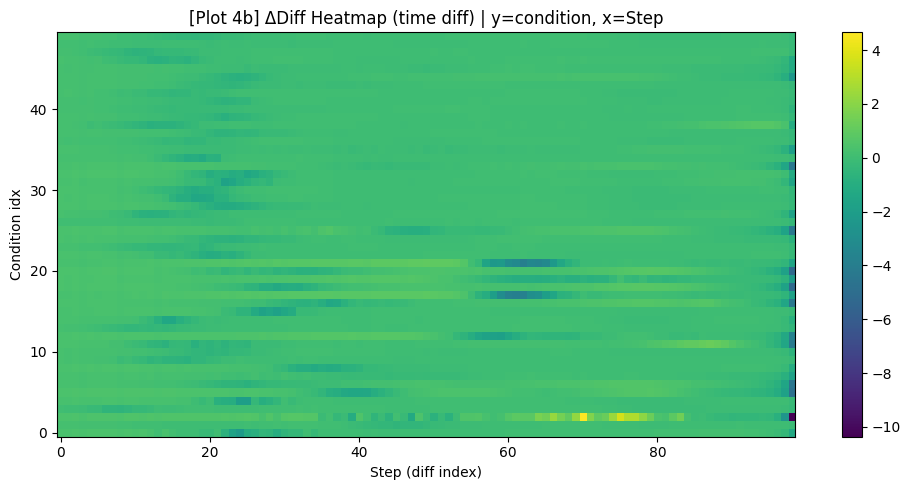

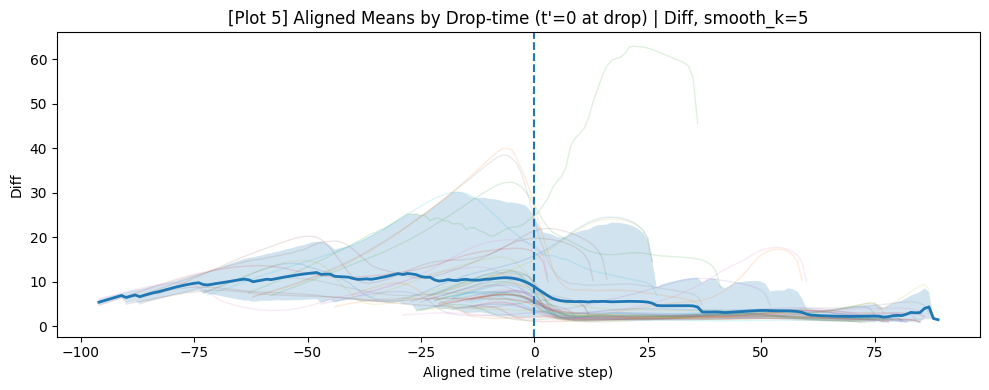

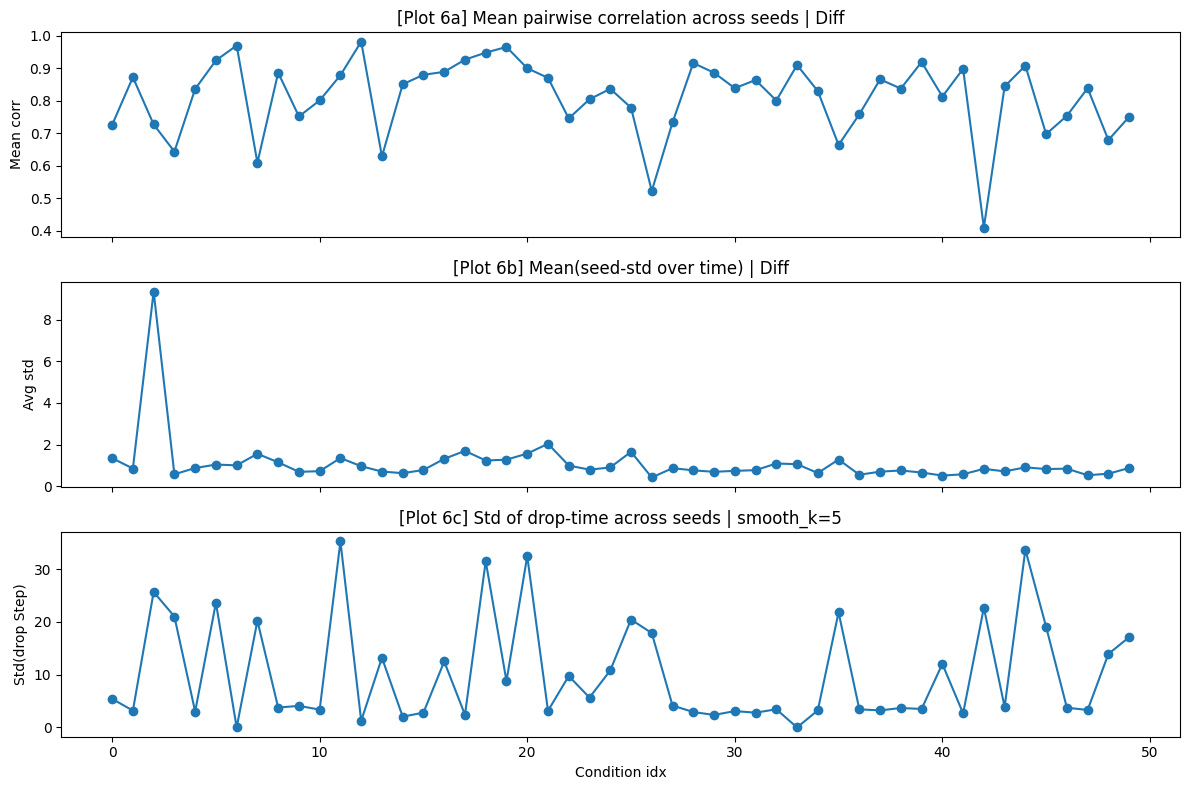

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0) Loader: ./results/pure_noise_basin_analysis/Memorized_{idx}/metrics.csv
# ============================================================
def load_all_conditions_exact(base_dir="./results/pure_noise_basin_analysis", idxs=range(50)):
    dfs = {}
    missing = []
    for idx in idxs:
        p = os.path.join(base_dir, f"Memorized_{idx}", "metrics.csv")
        if os.path.exists(p):
            dfs[idx] = pd.read_csv(p)
        else:
            missing.append(idx)

    if missing:
        print(f"[WARN] Missing conditions: {missing}")
        print("Example missing path:", os.path.join(base_dir, f"Memorized_{missing[0]}", "metrics.csv"))
        # 디렉토리 존재 여부도 같이 알려줌
        print("base_dir exists? ->", os.path.exists(base_dir))
    else:
        print("[OK] Loaded all conditions.")
    return dfs

# ============================================================
# 1) Utils: condition DataFrame -> seeds x steps matrix
# ============================================================
def df_to_matrix(df, metric_col="Diff", time_col="Step", seed_col="Sample_Idx"):
    d = df[[seed_col, time_col, metric_col]].copy().dropna()
    steps = np.sort(d[time_col].unique())
    seeds = np.sort(d[seed_col].unique())

    pivot = d.pivot_table(index=seed_col, columns=time_col, values=metric_col, aggfunc="mean")
    pivot = pivot.reindex(index=seeds, columns=steps)
    X = pivot.to_numpy()
    return steps, seeds, X

def smooth_1d(x, k=5):
    if k <= 1:
        return x
    k = int(k)
    w = np.ones(k) / k
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode="reflect")
    return np.convolve(xp, w, mode="valid")

def quantile_band(X, qs=(0.05, 0.95)):
    mu = np.nanmean(X, axis=0)
    lo = np.nanquantile(X, qs[0], axis=0)
    hi = np.nanquantile(X, qs[1], axis=0)
    sd = np.nanstd(X, axis=0)
    return mu, lo, hi, sd

def compute_drop_time_per_seed(X, steps, smooth_k=5):
    """
    Drop time tau: argmin_t (x[t+1]-x[t]) i.e., most negative slope.
    Returns tau_steps (S,), tau_pos (S,)
    """
    S, T = X.shape
    tau_pos = np.zeros(S, dtype=int)
    for i in range(S):
        y = X[i]
        if np.any(np.isnan(y)):
            y = pd.Series(y).interpolate(limit_direction="both").to_numpy()
        y = smooth_1d(y, k=smooth_k)
        dy = np.diff(y)
        tau_pos[i] = int(np.argmin(dy))
    tau_steps = steps[tau_pos]
    return tau_steps, tau_pos

def mean_pairwise_corr(X):
    X2 = X.copy()
    for i in range(X2.shape[0]):
        if np.any(np.isnan(X2[i])):
            X2[i] = pd.Series(X2[i]).interpolate(limit_direction="both").to_numpy()
    C = np.corrcoef(X2)  # (S,S)
    iu = np.triu_indices(C.shape[0], k=1)
    return float(np.nanmean(C[iu]))

# ============================================================
# Plot 1) Spaghetti + mean + quantile band (한 condition)
# ============================================================
def plot_1_spaghetti(df_cond, cond_idx, metric_col="Diff",
                     time_col="Step", seed_col="Sample_Idx",
                     q=(0.05, 0.95), max_seed_lines=None):
    steps, seeds, X = df_to_matrix(df_cond, metric_col, time_col, seed_col)
    mu, lo, hi, _ = quantile_band(X, qs=q)

    plt.figure(figsize=(9, 4))
    S = X.shape[0]
    order = np.arange(S)
    if (max_seed_lines is not None) and (S > max_seed_lines):
        order = order[:max_seed_lines]

    for i in order:
        plt.plot(steps, X[i], alpha=0.15, linewidth=1)
    plt.fill_between(steps, lo, hi, alpha=0.2)
    plt.plot(steps, mu, linewidth=2)

    plt.title(f"[Plot 1] Condition {cond_idx} | Spaghetti + Mean + {int(q[0]*100)}-{int(q[1]*100)}% Band ({metric_col})")
    plt.xlabel(time_col)
    plt.ylabel(metric_col)
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 2) Small multiples: 50 conditions mean+band
# ============================================================
def plot_2_small_multiples(dfs, metric_col="Diff",
                           time_col="Step", seed_col="Sample_Idx",
                           q=(0.05, 0.95), ncols=10):
    conds = sorted(dfs.keys())
    n = len(conds)
    ncols = int(ncols)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(2.0*ncols, 1.6*nrows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax_i, ax in enumerate(axes):
        if ax_i >= n:
            ax.axis("off")
            continue
        c = conds[ax_i]
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        mu, lo, hi, _ = quantile_band(X, qs=q)
        ax.fill_between(steps, lo, hi, alpha=0.2)
        ax.plot(steps, mu, linewidth=1.5)
        ax.set_title(f"{c}", fontsize=9)
        ax.tick_params(labelsize=8)

    fig.suptitle(f"[Plot 2] Small Multiples | Mean + {int(q[0]*100)}-{int(q[1]*100)}% Band ({metric_col})", y=1.02)
    fig.tight_layout()
    plt.show()

# ============================================================
# Plot 3) Drop-time: (a) raster for one condition, (b) boxplot across conditions
# ============================================================
def plot_3_event_and_distribution(dfs, focus_cond=0, metric_col="Diff",
                                  time_col="Step", seed_col="Sample_Idx",
                                  smooth_k=5, show_fliers=False):
    # 3a
    df_c = dfs[focus_cond]
    steps, seeds, X = df_to_matrix(df_c, metric_col, time_col, seed_col)
    tau_steps, _ = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)

    plt.figure(figsize=(9, 3.8))
    y = np.arange(len(seeds))
    plt.scatter(tau_steps, y, s=12)
    plt.title(f"[Plot 3a] Drop-time Raster | Condition {focus_cond} ({metric_col}), smooth_k={smooth_k}")
    plt.xlabel(time_col)
    plt.ylabel("Seed index (sorted)")
    plt.tight_layout()
    plt.show()

    # 3b
    conds = sorted(dfs.keys())
    tau_all = []
    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        tau_steps, _ = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_all.append(tau_steps)

    plt.figure(figsize=(12, 4))
    plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)
    plt.title(f"[Plot 3b] Drop-time Distribution Across Conditions | {metric_col}, smooth_k={smooth_k}")
    plt.xlabel("Condition idx")
    plt.ylabel(f"Drop time ({time_col})")
    plt.xticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 4) Heatmap: (a) mean value, (b) delta over time
# ============================================================
def plot_4_heatmaps(dfs, metric_col="Diff",
                    time_col="Step", seed_col="Sample_Idx",
                    smooth_k=1):
    conds = sorted(dfs.keys())

    mean_rows = []
    steps_ref = None
    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        mu, _, _, _ = quantile_band(X)
        if smooth_k > 1:
            mu = smooth_1d(mu, k=smooth_k)
        if steps_ref is None:
            steps_ref = steps
        else:
            if len(steps) != len(steps_ref) or np.any(steps != steps_ref):
                raise ValueError(f"Steps mismatch at condition {c}.")
        mean_rows.append(mu)

    M = np.stack(mean_rows, axis=0)  # (C,T)

    plt.figure(figsize=(10, 5))
    im = plt.imshow(M, aspect="auto", origin="lower")
    plt.colorbar(im)
    plt.title(f"[Plot 4a] Mean {metric_col} Heatmap | y=condition, x={time_col}")
    plt.xlabel(time_col)
    plt.ylabel("Condition idx")
    plt.tight_layout()
    plt.show()

    dM = np.diff(M, axis=1)  # (C,T-1)
    plt.figure(figsize=(10, 5))
    im2 = plt.imshow(dM, aspect="auto", origin="lower")
    plt.colorbar(im2)
    plt.title(f"[Plot 4b] Δ{metric_col} Heatmap (time diff) | y=condition, x={time_col}")
    plt.xlabel(f"{time_col} (diff index)")
    plt.ylabel("Condition idx")
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 5) Aligned mean curves by each condition's mean drop-time
# ============================================================
def plot_5_aligned_means(dfs, metric_col="Diff",
                         time_col="Step", seed_col="Sample_Idx",
                         smooth_k=5):
    conds = sorted(dfs.keys())

    curves = []
    taus = []
    steps_ref = None

    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        mu, _, _, _ = quantile_band(X)
        if steps_ref is None:
            steps_ref = steps
        tau_steps, tau_pos = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_mean_pos = int(np.round(np.mean(tau_pos)))
        taus.append(tau_mean_pos)
        curves.append(mu)

    curves = np.stack(curves, axis=0)  # (C,T)
    taus = np.array(taus)              # (C,)

    T = curves.shape[1]
    left = int(np.max(taus))
    right = int(np.max((T-1) - taus))
    x_aligned = np.arange(-left, right+1)

    A = np.full((len(conds), len(x_aligned)), np.nan, dtype=float)
    for i, (mu, tau_pos) in enumerate(zip(curves, taus)):
        start = left - tau_pos
        A[i, start:start+T] = mu

    A_mean = np.nanmean(A, axis=0)
    A_lo = np.nanquantile(A, 0.05, axis=0)
    A_hi = np.nanquantile(A, 0.95, axis=0)

    plt.figure(figsize=(10, 4))
    for i in range(A.shape[0]):
        plt.plot(x_aligned, A[i], alpha=0.15, linewidth=1)
    plt.fill_between(x_aligned, A_lo, A_hi, alpha=0.2)
    plt.plot(x_aligned, A_mean, linewidth=2)
    plt.axvline(0, linestyle="--")

    plt.title(f"[Plot 5] Aligned Means by Drop-time (t'=0 at drop) | {metric_col}, smooth_k={smooth_k}")
    plt.xlabel("Aligned time (relative step)")
    plt.ylabel(metric_col)
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 6) Reproducibility metrics per condition
# ============================================================
def plot_6_reproducibility(dfs, metric_col="Diff",
                           time_col="Step", seed_col="Sample_Idx",
                           smooth_k=5):
    conds = sorted(dfs.keys())

    corr_means = []
    seed_std_means = []
    tau_stds = []

    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        corr_means.append(mean_pairwise_corr(X))
        seed_std_means.append(float(np.nanmean(np.nanstd(X, axis=0))))
        tau_steps, _ = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_stds.append(float(np.nanstd(tau_steps)))

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(conds, corr_means, marker="o", linewidth=1.5)
    axes[0].set_title(f"[Plot 6a] Mean pairwise correlation across seeds | {metric_col}")
    axes[0].set_ylabel("Mean corr")

    axes[1].plot(conds, seed_std_means, marker="o", linewidth=1.5)
    axes[1].set_title(f"[Plot 6b] Mean(seed-std over time) | {metric_col}")
    axes[1].set_ylabel("Avg std")

    axes[2].plot(conds, tau_stds, marker="o", linewidth=1.5)
    axes[2].set_title(f"[Plot 6c] Std of drop-time across seeds | smooth_k={smooth_k}")
    axes[2].set_ylabel(f"Std(drop {time_col})")
    axes[2].set_xlabel("Condition idx")

    fig.tight_layout()
    plt.show()

# ============================================================
# Run
# ============================================================
dfs = load_all_conditions_exact(base_dir="./results/pure_noise_basin_analysis", idxs=range(50))

metric_col = "Diff"  # "Jacobian" or "AttnStability"

plot_1_spaghetti(dfs[0], cond_idx=0, metric_col=metric_col)
plot_2_small_multiples(dfs, metric_col=metric_col, ncols=10)
plot_3_event_and_distribution(dfs, focus_cond=0, metric_col=metric_col, smooth_k=5)
plot_4_heatmaps(dfs, metric_col=metric_col, smooth_k=1)
plot_5_aligned_means(dfs, metric_col=metric_col, smooth_k=5)
plot_6_reproducibility(dfs, metric_col=metric_col, smooth_k=5)


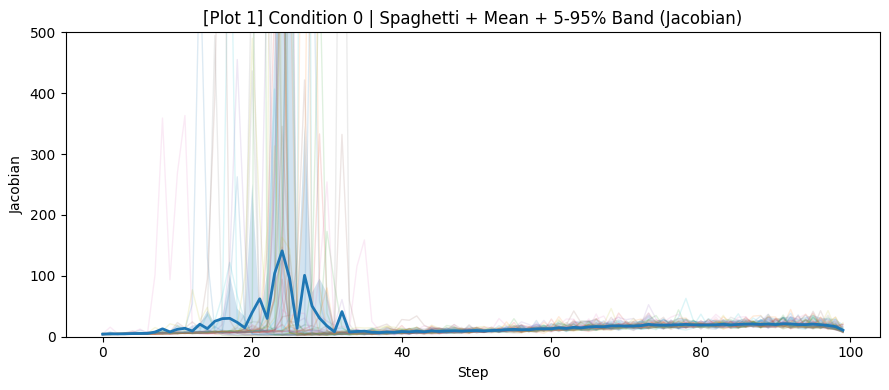

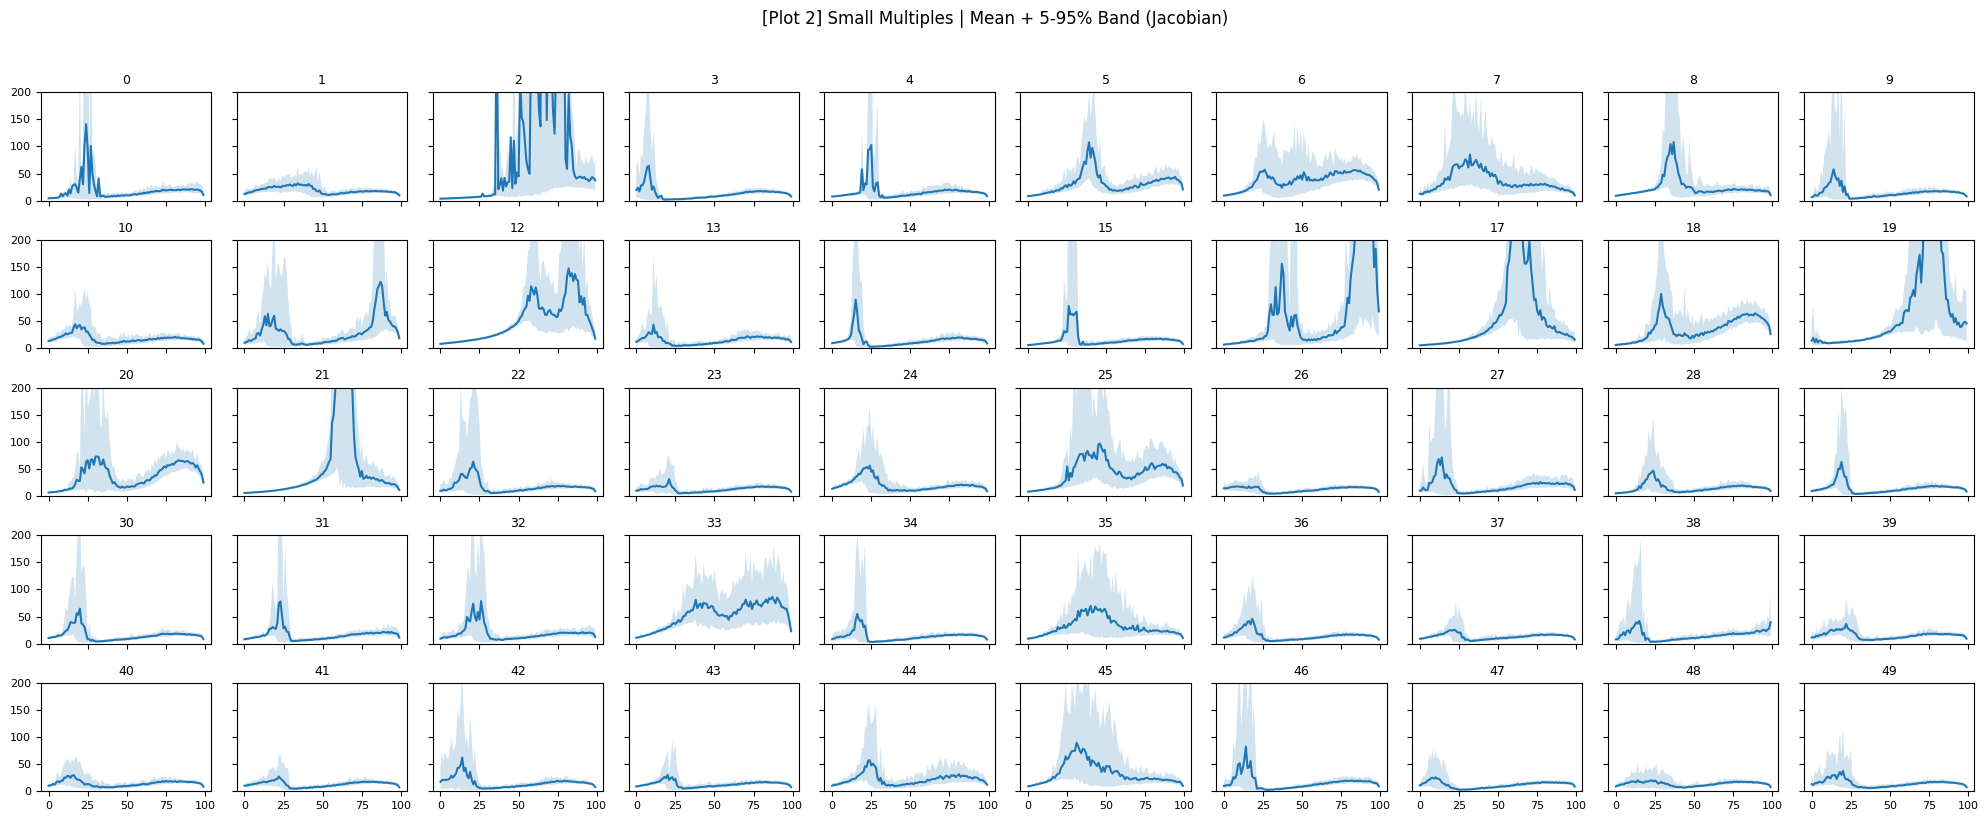

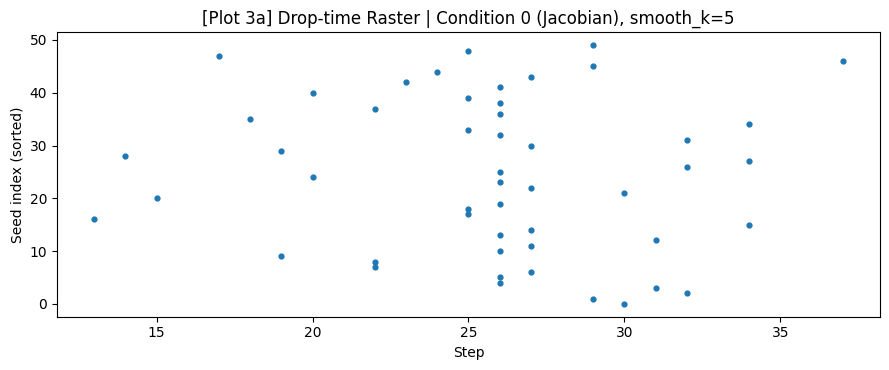

/tmp/ipykernel_793769/1262170380.py:165: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)


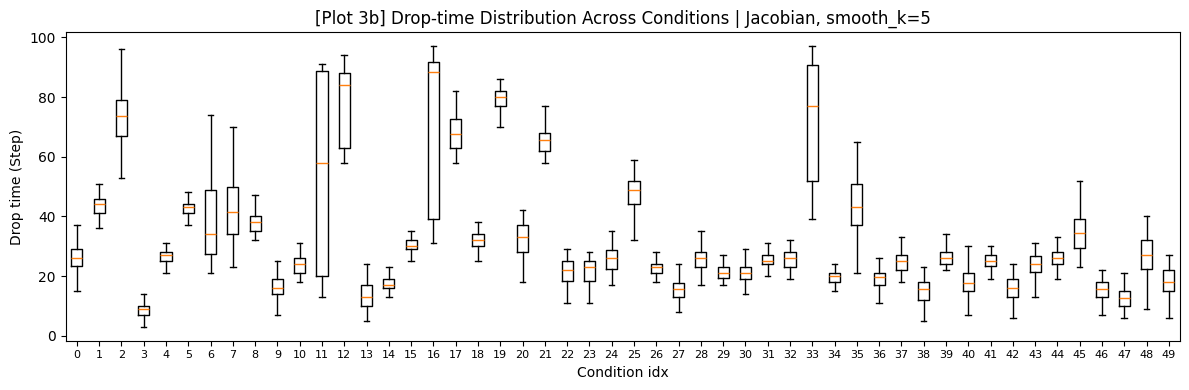

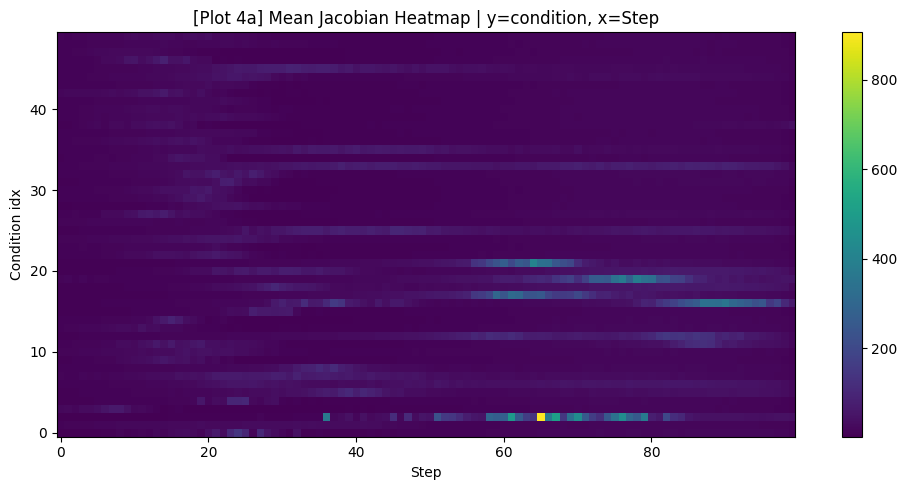

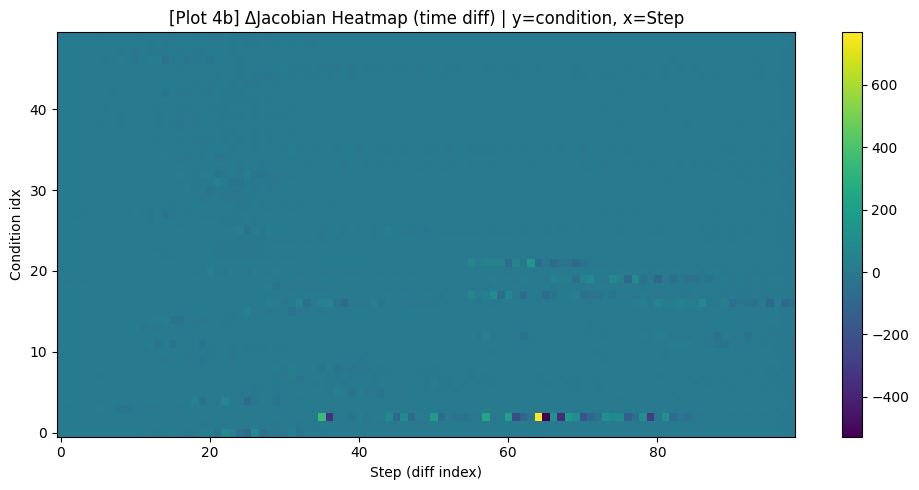

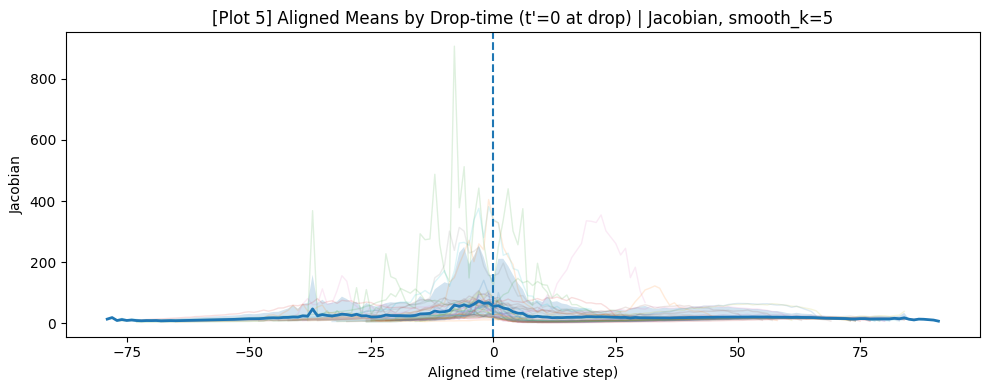

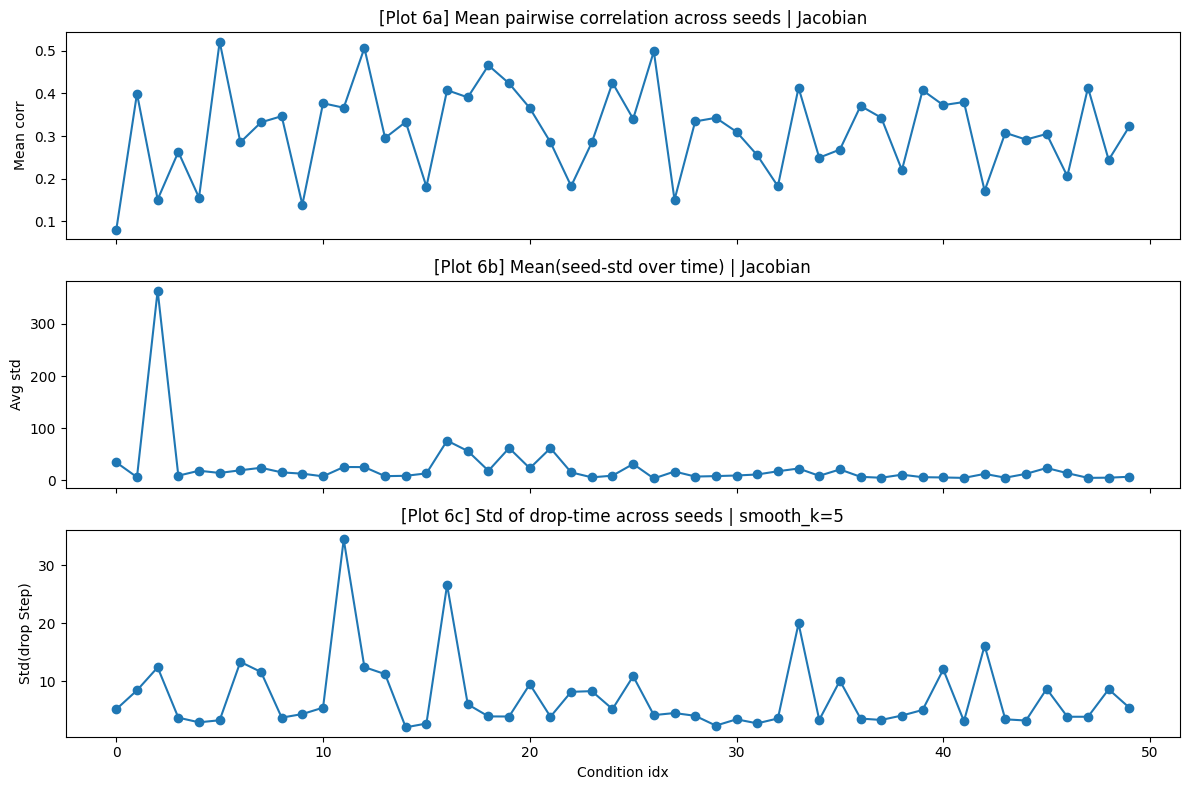

In [2]:
# ============================================================
# 0) Loader: ./results/pure_noise_basin_analysis/Memorized_{idx}/metrics.csv
# ============================================================
def load_all_conditions_exact(base_dir="./results/pure_noise_basin_analysis", idxs=range(50)):
    dfs = {}
    missing = []
    for idx in idxs:
        p = os.path.join(base_dir, f"Memorized_{idx}", "metrics.csv")
        if os.path.exists(p):
            dfs[idx] = pd.read_csv(p)
        else:
            missing.append(idx)

    if missing:
        print(f"[WARN] Missing conditions: {missing}")
        print("Example missing path:", os.path.join(base_dir, f"Memorized_{missing[0]}", "metrics.csv"))
        # 디렉토리 존재 여부도 같이 알려줌
        print("base_dir exists? ->", os.path.exists(base_dir))
    else:
        print("[OK] Loaded all conditions.")
    return dfs

# ============================================================
# 1) Utils: condition DataFrame -> seeds x steps matrix
# ============================================================
def df_to_matrix(df, metric_col="Diff", time_col="Step", seed_col="Sample_Idx"):
    d = df[[seed_col, time_col, metric_col]].copy().dropna()
    steps = np.sort(d[time_col].unique())
    seeds = np.sort(d[seed_col].unique())

    pivot = d.pivot_table(index=seed_col, columns=time_col, values=metric_col, aggfunc="mean")
    pivot = pivot.reindex(index=seeds, columns=steps)
    X = pivot.to_numpy()
    return steps, seeds, X

def smooth_1d(x, k=5):
    if k <= 1:
        return x
    k = int(k)
    w = np.ones(k) / k
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode="reflect")
    return np.convolve(xp, w, mode="valid")

def quantile_band(X, qs=(0.05, 0.95)):
    mu = np.nanmean(X, axis=0)
    lo = np.nanquantile(X, qs[0], axis=0)
    hi = np.nanquantile(X, qs[1], axis=0)
    sd = np.nanstd(X, axis=0)
    return mu, lo, hi, sd

def compute_drop_time_per_seed(X, steps, smooth_k=5):
    """
    Drop time tau: argmin_t (x[t+1]-x[t]) i.e., most negative slope.
    Returns tau_steps (S,), tau_pos (S,)
    """
    S, T = X.shape
    tau_pos = np.zeros(S, dtype=int)
    for i in range(S):
        y = X[i]
        if np.any(np.isnan(y)):
            y = pd.Series(y).interpolate(limit_direction="both").to_numpy()
        y = smooth_1d(y, k=smooth_k)
        dy = np.diff(y)
        tau_pos[i] = int(np.argmin(dy))
    tau_steps = steps[tau_pos]
    return tau_steps, tau_pos

def mean_pairwise_corr(X):
    X2 = X.copy()
    for i in range(X2.shape[0]):
        if np.any(np.isnan(X2[i])):
            X2[i] = pd.Series(X2[i]).interpolate(limit_direction="both").to_numpy()
    C = np.corrcoef(X2)  # (S,S)
    iu = np.triu_indices(C.shape[0], k=1)
    return float(np.nanmean(C[iu]))

# ============================================================
# Plot 1) Spaghetti + mean + quantile band (한 condition)
# ============================================================
def plot_1_spaghetti(df_cond, cond_idx, metric_col="Diff",
                     time_col="Step", seed_col="Sample_Idx",
                     q=(0.05, 0.95), max_seed_lines=None):
    steps, seeds, X = df_to_matrix(df_cond, metric_col, time_col, seed_col)
    mu, lo, hi, _ = quantile_band(X, qs=q)

    plt.figure(figsize=(9, 4))
    S = X.shape[0]
    order = np.arange(S)
    if (max_seed_lines is not None) and (S > max_seed_lines):
        order = order[:max_seed_lines]

    for i in order:
        plt.plot(steps, X[i], alpha=0.15, linewidth=1)
    plt.fill_between(steps, lo, hi, alpha=0.2)
    plt.plot(steps, mu, linewidth=2)

    plt.title(f"[Plot 1] Condition {cond_idx} | Spaghetti + Mean + {int(q[0]*100)}-{int(q[1]*100)}% Band ({metric_col})")
    plt.xlabel(time_col)
    plt.ylabel(metric_col)
    plt.ylim(0, 500)
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 2) Small multiples: 50 conditions mean+band
# ============================================================
def plot_2_small_multiples(dfs, metric_col="Diff",
                           time_col="Step", seed_col="Sample_Idx",
                           q=(0.05, 0.95), ncols=10):
    conds = sorted(dfs.keys())
    n = len(conds)
    ncols = int(ncols)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(2.0*ncols, 1.6*nrows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax_i, ax in enumerate(axes):
        if ax_i >= n:
            ax.axis("off")
            continue
        c = conds[ax_i]
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        mu, lo, hi, _ = quantile_band(X, qs=q)
        ax.fill_between(steps, lo, hi, alpha=0.2)
        ax.plot(steps, mu, linewidth=1.5)
        ax.set_title(f"{c}", fontsize=9)
        ax.tick_params(labelsize=8)
        ax.set_ylim(0, 200)

    fig.suptitle(f"[Plot 2] Small Multiples | Mean + {int(q[0]*100)}-{int(q[1]*100)}% Band ({metric_col})", y=1.02)
    fig.tight_layout()
    plt.show()

# ============================================================
# Plot 3) Drop-time: (a) raster for one condition, (b) boxplot across conditions
# ============================================================
def plot_3_event_and_distribution(dfs, focus_cond=0, metric_col="Diff",
                                  time_col="Step", seed_col="Sample_Idx",
                                  smooth_k=5, show_fliers=False):
    # 3a
    df_c = dfs[focus_cond]
    steps, seeds, X = df_to_matrix(df_c, metric_col, time_col, seed_col)
    tau_steps, _ = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)

    plt.figure(figsize=(9, 3.8))
    y = np.arange(len(seeds))
    plt.scatter(tau_steps, y, s=12)
    plt.title(f"[Plot 3a] Drop-time Raster | Condition {focus_cond} ({metric_col}), smooth_k={smooth_k}")
    plt.xlabel(time_col)
    plt.ylabel("Seed index (sorted)")
    plt.tight_layout()
    plt.show()

    # 3b
    conds = sorted(dfs.keys())
    tau_all = []
    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        tau_steps, _ = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_all.append(tau_steps)

    plt.figure(figsize=(12, 4))
    plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)
    plt.title(f"[Plot 3b] Drop-time Distribution Across Conditions | {metric_col}, smooth_k={smooth_k}")
    plt.xlabel("Condition idx")
    plt.ylabel(f"Drop time ({time_col})")
    plt.xticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 4) Heatmap: (a) mean value, (b) delta over time
# ============================================================
def plot_4_heatmaps(dfs, metric_col="Diff",
                    time_col="Step", seed_col="Sample_Idx",
                    smooth_k=1):
    conds = sorted(dfs.keys())

    mean_rows = []
    steps_ref = None
    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        mu, _, _, _ = quantile_band(X)
        if smooth_k > 1:
            mu = smooth_1d(mu, k=smooth_k)
        if steps_ref is None:
            steps_ref = steps
        else:
            if len(steps) != len(steps_ref) or np.any(steps != steps_ref):
                raise ValueError(f"Steps mismatch at condition {c}.")
        mean_rows.append(mu)

    M = np.stack(mean_rows, axis=0)  # (C,T)

    plt.figure(figsize=(10, 5))
    im = plt.imshow(M, aspect="auto", origin="lower")
    plt.colorbar(im)
    plt.title(f"[Plot 4a] Mean {metric_col} Heatmap | y=condition, x={time_col}")
    plt.xlabel(time_col)
    plt.ylabel("Condition idx")
    plt.tight_layout()
    plt.show()

    dM = np.diff(M, axis=1)  # (C,T-1)
    plt.figure(figsize=(10, 5))
    im2 = plt.imshow(dM, aspect="auto", origin="lower")
    plt.colorbar(im2)
    plt.title(f"[Plot 4b] Δ{metric_col} Heatmap (time diff) | y=condition, x={time_col}")
    plt.xlabel(f"{time_col} (diff index)")
    plt.ylabel("Condition idx")
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 5) Aligned mean curves by each condition's mean drop-time
# ============================================================
def plot_5_aligned_means(dfs, metric_col="Diff",
                         time_col="Step", seed_col="Sample_Idx",
                         smooth_k=5):
    conds = sorted(dfs.keys())

    curves = []
    taus = []
    steps_ref = None

    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        mu, _, _, _ = quantile_band(X)
        if steps_ref is None:
            steps_ref = steps
        tau_steps, tau_pos = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_mean_pos = int(np.round(np.mean(tau_pos)))
        taus.append(tau_mean_pos)
        curves.append(mu)

    curves = np.stack(curves, axis=0)  # (C,T)
    taus = np.array(taus)              # (C,)

    T = curves.shape[1]
    left = int(np.max(taus))
    right = int(np.max((T-1) - taus))
    x_aligned = np.arange(-left, right+1)

    A = np.full((len(conds), len(x_aligned)), np.nan, dtype=float)
    for i, (mu, tau_pos) in enumerate(zip(curves, taus)):
        start = left - tau_pos
        A[i, start:start+T] = mu

    A_mean = np.nanmean(A, axis=0)
    A_lo = np.nanquantile(A, 0.05, axis=0)
    A_hi = np.nanquantile(A, 0.95, axis=0)

    plt.figure(figsize=(10, 4))
    for i in range(A.shape[0]):
        plt.plot(x_aligned, A[i], alpha=0.15, linewidth=1)
    plt.fill_between(x_aligned, A_lo, A_hi, alpha=0.2)
    plt.plot(x_aligned, A_mean, linewidth=2)
    plt.axvline(0, linestyle="--")

    plt.title(f"[Plot 5] Aligned Means by Drop-time (t'=0 at drop) | {metric_col}, smooth_k={smooth_k}")
    plt.xlabel("Aligned time (relative step)")
    plt.ylabel(metric_col)
    plt.tight_layout()
    plt.show()

# ============================================================
# Plot 6) Reproducibility metrics per condition
# ============================================================
def plot_6_reproducibility(dfs, metric_col="Diff",
                           time_col="Step", seed_col="Sample_Idx",
                           smooth_k=5):
    conds = sorted(dfs.keys())

    corr_means = []
    seed_std_means = []
    tau_stds = []

    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        corr_means.append(mean_pairwise_corr(X))
        seed_std_means.append(float(np.nanmean(np.nanstd(X, axis=0))))
        tau_steps, _ = compute_drop_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_stds.append(float(np.nanstd(tau_steps)))

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(conds, corr_means, marker="o", linewidth=1.5)
    axes[0].set_title(f"[Plot 6a] Mean pairwise correlation across seeds | {metric_col}")
    axes[0].set_ylabel("Mean corr")

    axes[1].plot(conds, seed_std_means, marker="o", linewidth=1.5)
    axes[1].set_title(f"[Plot 6b] Mean(seed-std over time) | {metric_col}")
    axes[1].set_ylabel("Avg std")

    axes[2].plot(conds, tau_stds, marker="o", linewidth=1.5)
    axes[2].set_title(f"[Plot 6c] Std of drop-time across seeds | smooth_k={smooth_k}")
    axes[2].set_ylabel(f"Std(drop {time_col})")
    axes[2].set_xlabel("Condition idx")

    fig.tight_layout()
    plt.show()

metric_col = "Jacobian"  # "Jacobian" or "AttnStability"

plot_1_spaghetti(dfs[0], cond_idx=0, metric_col=metric_col)
plot_2_small_multiples(dfs, metric_col=metric_col, ncols=10)
plot_3_event_and_distribution(dfs, focus_cond=0, metric_col=metric_col, smooth_k=5)
plot_4_heatmaps(dfs, metric_col=metric_col, smooth_k=1)
plot_5_aligned_means(dfs, metric_col=metric_col, smooth_k=5)
plot_6_reproducibility(dfs, metric_col=metric_col, smooth_k=5)

Loaded data shape: (250000, 9)
Plotting Recommendation 1...


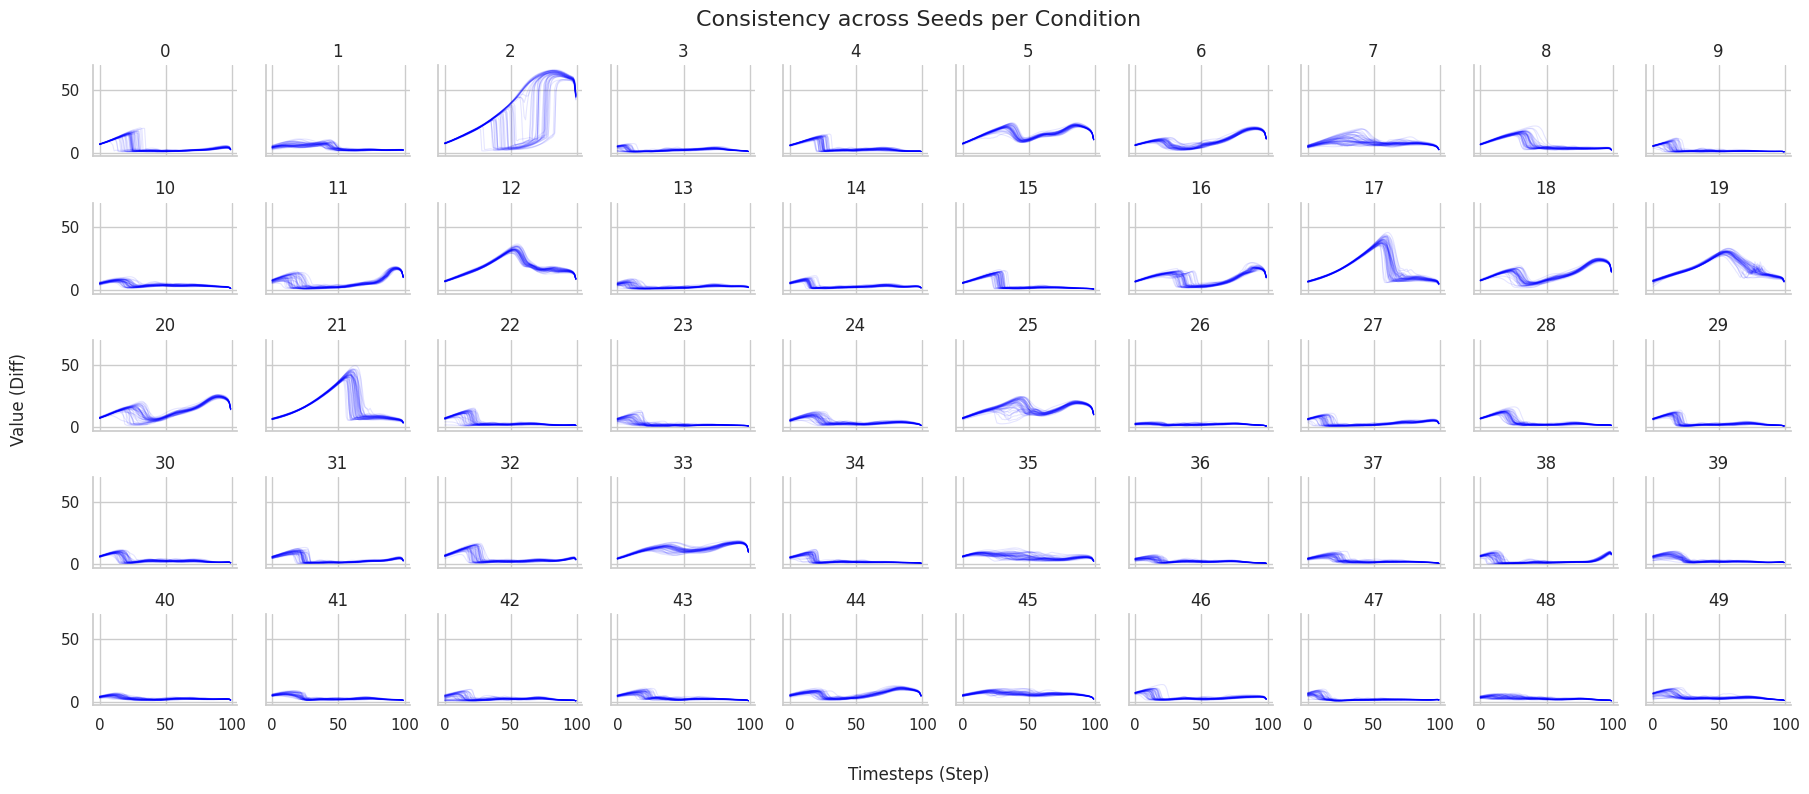

Plotting Recommendation 2...


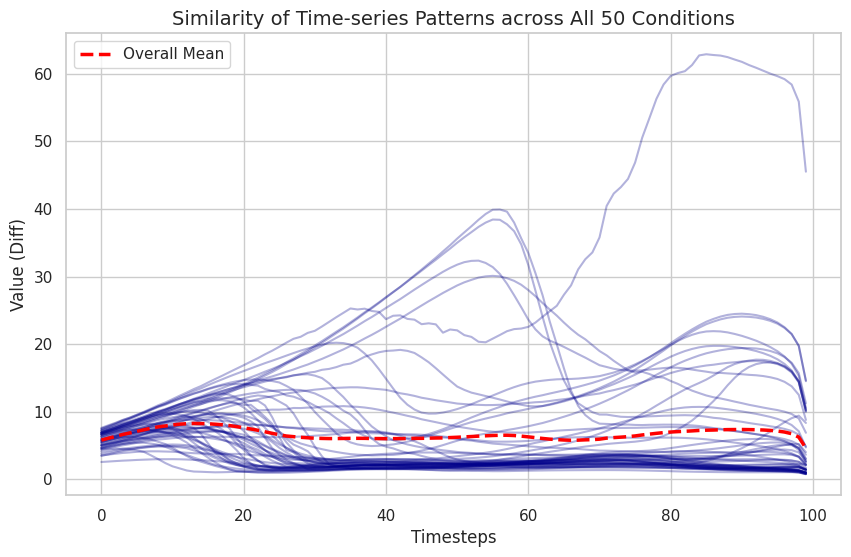

Plotting Recommendation 3...


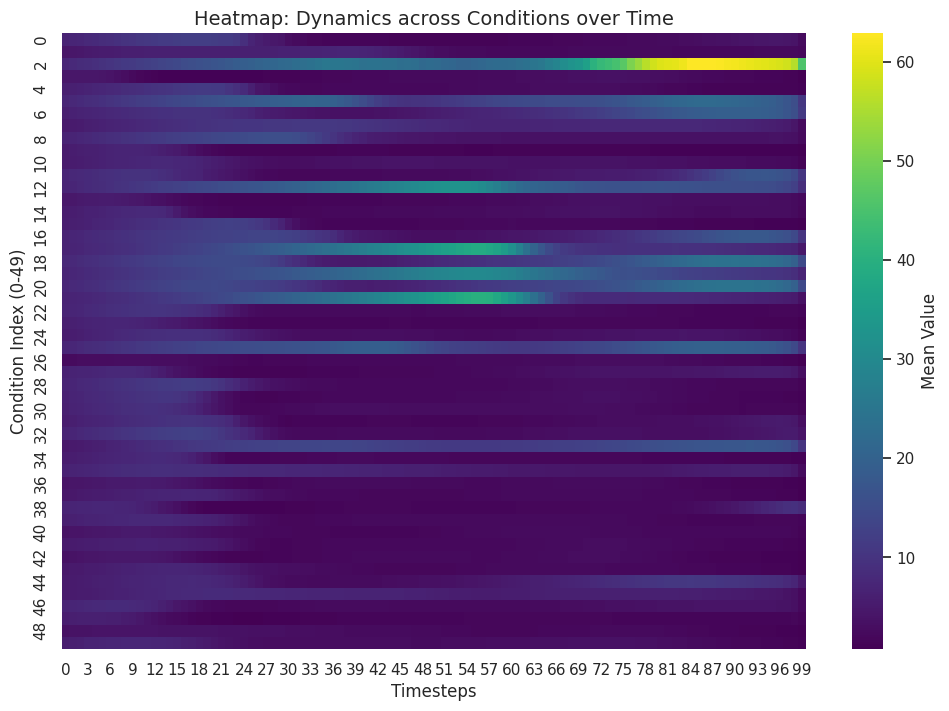

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# ==========================================
# 1. 데이터 로드 (Data Loading)
# ==========================================

# 50개의 Condition 데이터를 리스트에 담아 합칩니다.
all_data = []
num_conditions = 50

for idx in range(num_conditions):
    # 파일 경로 설정 (사용자 환경에 맞춤)
    file_path = f'./results/pure_noise_basin_analysis/Memorized_{idx}/metrics.csv'
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Condition'] = idx  # Condition 식별자 컬럼 추가
        all_data.append(df)
    else:
        print(f"Warning: File not found for Condition {idx}")

if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    print(f"Loaded data shape: {full_df.shape}")
else:
    print("No data loaded. Please check the file paths.")
    # (참고) 실행 테스트를 위해 가상의 데이터를 만들 경우에만 사용하세요.
    # full_df = ... 

# 시각화 설정
sns.set_theme(style="whitegrid")
x_col = 'Step'       # X축: 시간 단계 (0~99)
y_col = 'Diff'       # Y축: 관측 값 (예: Diff)
seed_col = 'Sample_Idx' # Seed 구분

# ==========================================
# 2. 추천 Plotting 코드 구현
# ==========================================

# --- 추천 1: Small Multiples (Faceted Line Plot) ---
# 목적: Condition 별로 Seed들이 얼마나 뭉쳐있는지(유사한지) 개별적으로 확인
# 강조점 1: "Condition이 같으면 Seed에 상관없이 유사하다"
def plot_small_multiples(df):
    # col_wrap=10: 한 줄에 10개씩 5줄로 배치 (5x10 = 50개)
    g = sns.FacetGrid(df, col='Condition', col_wrap=10, height=1.5, aspect=1.2, 
                      sharex=True, sharey=True)
    
    # 투명도(alpha)를 낮게 주어 데이터가 뭉친 곳을 진하게 표현
    g.map_dataframe(sns.lineplot, x=x_col, y=y_col, units=seed_col, 
                    estimator=None, color='blue', alpha=0.1, linewidth=0.8)
    
    g.set_titles("{col_name}")  # 제목 간소화
    g.set_axis_labels("", "")   # 축 라벨 간소화 (공간 확보)
    g.fig.suptitle('Consistency across Seeds per Condition', fontsize=16, y=1.02)
    
    # 전체 X, Y 라벨 추가
    g.fig.text(0.5, 0.0, 'Timesteps (Step)', ha='center', va='center')
    g.fig.text(0.0, 0.5, 'Value (Diff)', ha='center', va='center', rotation='vertical')
    
    plt.show()

# --- 추천 2: Aggregated Lines (Spaghetti Plot of Means) ---
# 목적: 모든 Condition의 패턴을 한 곳에 겹쳐 그림
# 강조점 3: "특정이 아닌, 대부분의 Condition에서 동일한 패턴이 나타난다"
def plot_aggregated_lines(df):
    plt.figure(figsize=(10, 6))
    
    # 각 Condition 별로 Seed들의 평균 계산
    condition_means = df.groupby(['Condition', x_col])[y_col].mean().reset_index()
    
    # Condition 별 평균 선을 겹쳐 그리기 (units='Condition')
    sns.lineplot(data=condition_means, x=x_col, y=y_col, units='Condition', estimator=None, 
                 alpha=0.3, color='darkblue', linewidth=1.5)
    
    # 전체 평균선 (붉은 점선) 추가
    overall_mean = df.groupby(x_col)[y_col].mean()
    plt.plot(overall_mean.index, overall_mean.values, color='red', linestyle='--', 
             linewidth=2.5, label='Overall Mean')
    
    plt.title('Similarity of Time-series Patterns across All 50 Conditions', fontsize=14)
    plt.xlabel('Timesteps')
    plt.ylabel('Value (Diff)')
    plt.legend()
    plt.show()

# --- 추천 3: Heatmap ---
# 목적: 2D 평면에서 Condition x Time 의 전체적인 흐름 조망
# 강조점 2: "급감하는 지점이 유사한 시점에서 등장한다"
def plot_heatmap(df):
    plt.figure(figsize=(12, 8))
    
    # 데이터 피벗: Condition(행) x Step(열) = 값(Seed 평균)
    pivot_df = df.groupby(['Condition', x_col])[y_col].mean().unstack()
    
    # Heatmap 그리기
    sns.heatmap(pivot_df, cmap='viridis', cbar_kws={'label': 'Mean Value'})
    
    plt.title('Heatmap: Dynamics across Conditions over Time', fontsize=14)
    plt.xlabel('Timesteps')
    plt.ylabel('Condition Index (0-49)')
    plt.show()

# ==========================================
# 3. 실행
# ==========================================
if 'full_df' in locals():
    print("Plotting Recommendation 1...")
    plot_small_multiples(full_df)
    
    print("Plotting Recommendation 2...")
    plot_aggregated_lines(full_df)
    
    print("Plotting Recommendation 3...")
    plot_heatmap(full_df)

Loaded data shape: (250000, 9)
Plotting Recommendation 1...


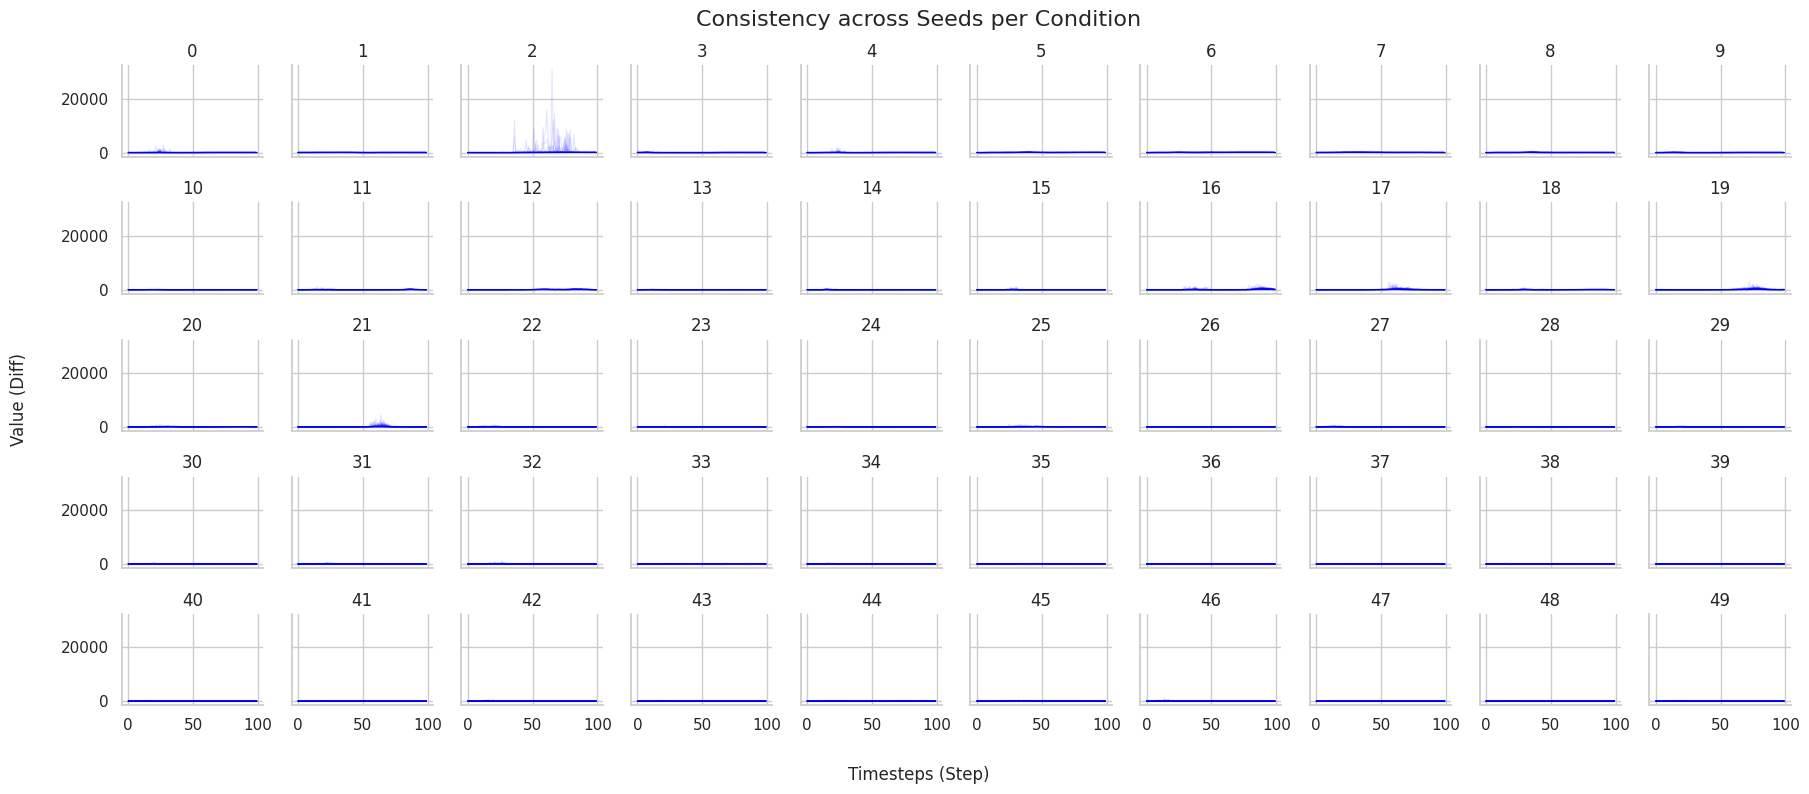

Plotting Recommendation 2...


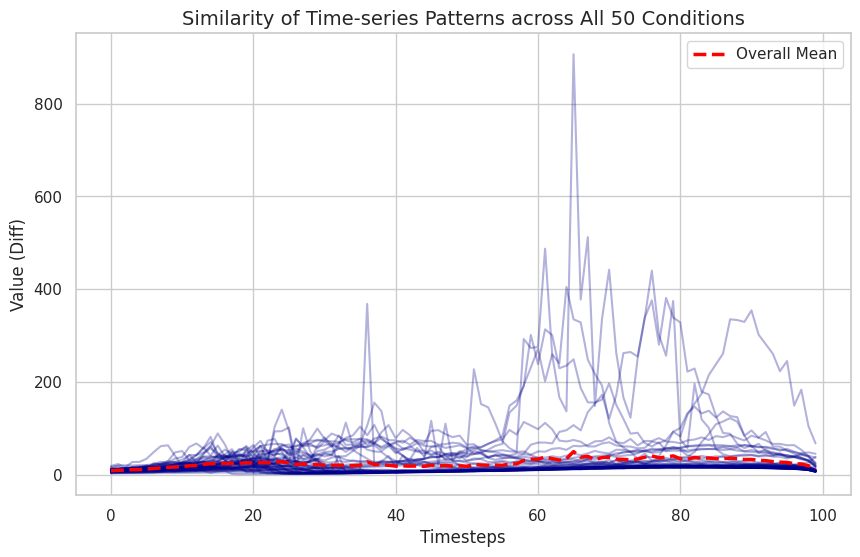

Plotting Recommendation 3...


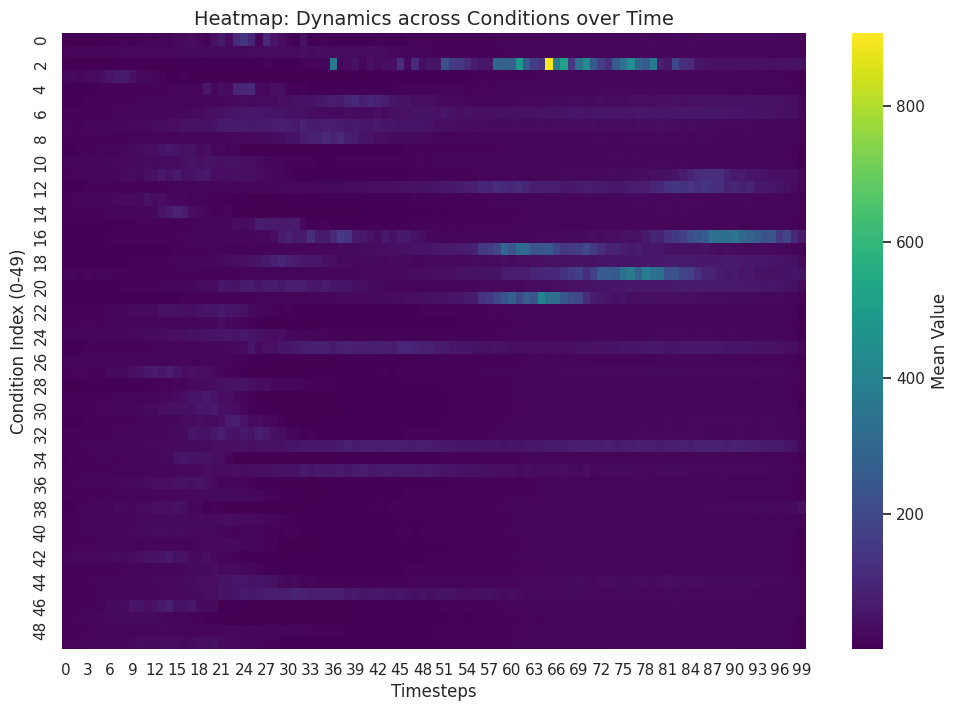

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# ==========================================
# 1. 데이터 로드 (Data Loading)
# ==========================================

# 50개의 Condition 데이터를 리스트에 담아 합칩니다.
all_data = []
num_conditions = 50

for idx in range(num_conditions):
    # 파일 경로 설정 (사용자 환경에 맞춤)
    file_path = f'./results/pure_noise_basin_analysis/Memorized_{idx}/metrics.csv'
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Condition'] = idx  # Condition 식별자 컬럼 추가
        all_data.append(df)
    else:
        print(f"Warning: File not found for Condition {idx}")

if all_data:
    full_df = pd.concat(all_data, ignore_index=True)
    print(f"Loaded data shape: {full_df.shape}")
else:
    print("No data loaded. Please check the file paths.")
    # (참고) 실행 테스트를 위해 가상의 데이터를 만들 경우에만 사용하세요.
    # full_df = ... 

# 시각화 설정
sns.set_theme(style="whitegrid")
x_col = 'Step'       # X축: 시간 단계 (0~99)
y_col = 'Jacobian'       # Y축: 관측 값 (예: Diff)
seed_col = 'Sample_Idx' # Seed 구분

# ==========================================
# 2. 추천 Plotting 코드 구현
# ==========================================

# --- 추천 1: Small Multiples (Faceted Line Plot) ---
# 목적: Condition 별로 Seed들이 얼마나 뭉쳐있는지(유사한지) 개별적으로 확인
# 강조점 1: "Condition이 같으면 Seed에 상관없이 유사하다"
def plot_small_multiples(df):
    # col_wrap=10: 한 줄에 10개씩 5줄로 배치 (5x10 = 50개)
    g = sns.FacetGrid(df, col='Condition', col_wrap=10, height=1.5, aspect=1.2, 
                      sharex=True, sharey=True)
    
    # 투명도(alpha)를 낮게 주어 데이터가 뭉친 곳을 진하게 표현
    g.map_dataframe(sns.lineplot, x=x_col, y=y_col, units=seed_col, 
                    estimator=None, color='blue', alpha=0.1, linewidth=0.8)
    
    g.set_titles("{col_name}")  # 제목 간소화
    g.set_axis_labels("", "")   # 축 라벨 간소화 (공간 확보)
    g.fig.suptitle('Consistency across Seeds per Condition', fontsize=16, y=1.02)
    
    # 전체 X, Y 라벨 추가
    g.fig.text(0.5, 0.0, 'Timesteps (Step)', ha='center', va='center')
    g.fig.text(0.0, 0.5, 'Value (Diff)', ha='center', va='center', rotation='vertical')
    
    plt.show()

# --- 추천 2: Aggregated Lines (Spaghetti Plot of Means) ---
# 목적: 모든 Condition의 패턴을 한 곳에 겹쳐 그림
# 강조점 3: "특정이 아닌, 대부분의 Condition에서 동일한 패턴이 나타난다"
def plot_aggregated_lines(df):
    plt.figure(figsize=(10, 6))
    
    # 각 Condition 별로 Seed들의 평균 계산
    condition_means = df.groupby(['Condition', x_col])[y_col].mean().reset_index()
    
    # Condition 별 평균 선을 겹쳐 그리기 (units='Condition')
    sns.lineplot(data=condition_means, x=x_col, y=y_col, units='Condition', estimator=None, 
                 alpha=0.3, color='darkblue', linewidth=1.5)
    
    # 전체 평균선 (붉은 점선) 추가
    overall_mean = df.groupby(x_col)[y_col].mean()
    plt.plot(overall_mean.index, overall_mean.values, color='red', linestyle='--', 
             linewidth=2.5, label='Overall Mean')
    
    plt.title('Similarity of Time-series Patterns across All 50 Conditions', fontsize=14)
    plt.xlabel('Timesteps')
    plt.ylabel('Value (Diff)')
    plt.legend()
    plt.show()

# --- 추천 3: Heatmap ---
# 목적: 2D 평면에서 Condition x Time 의 전체적인 흐름 조망
# 강조점 2: "급감하는 지점이 유사한 시점에서 등장한다"
def plot_heatmap(df):
    plt.figure(figsize=(12, 8))
    
    # 데이터 피벗: Condition(행) x Step(열) = 값(Seed 평균)
    pivot_df = df.groupby(['Condition', x_col])[y_col].mean().unstack()
    
    # Heatmap 그리기
    sns.heatmap(pivot_df, cmap='viridis', cbar_kws={'label': 'Mean Value'})
    
    plt.title('Heatmap: Dynamics across Conditions over Time', fontsize=14)
    plt.xlabel('Timesteps')
    plt.ylabel('Condition Index (0-49)')
    plt.show()

# ==========================================
# 3. 실행
# ==========================================
if 'full_df' in locals():
    print("Plotting Recommendation 1...")
    plot_small_multiples(full_df)
    
    print("Plotting Recommendation 2...")
    plot_aggregated_lines(full_df)
    
    print("Plotting Recommendation 3...")
    plot_heatmap(full_df)

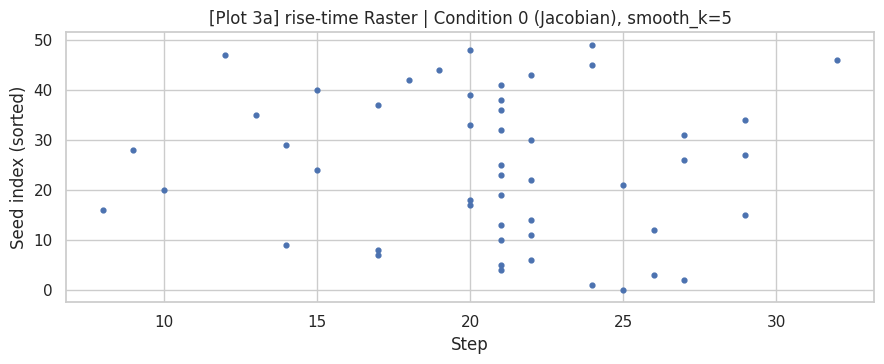

/tmp/ipykernel_793769/2801313983.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)


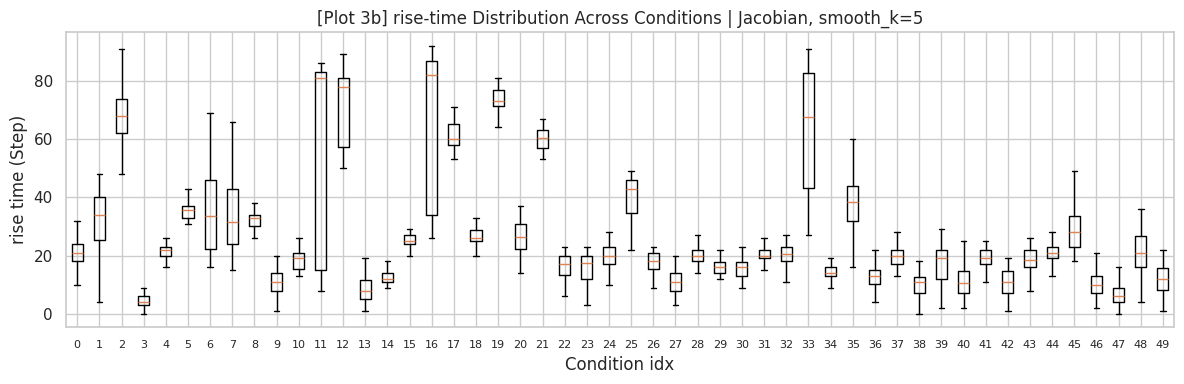

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def smooth_1d(x, k=5):
    if k <= 1:
        return x
    k = int(k)
    w = np.ones(k) / k
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode="reflect")
    return np.convolve(xp, w, mode="valid")

def df_to_matrix(df, metric_col="Diff", time_col="Step", seed_col="Sample_Idx"):
    d = df[[seed_col, time_col, metric_col]].copy().dropna()
    steps = np.sort(d[time_col].unique())
    seeds = np.sort(d[seed_col].unique())

    pivot = d.pivot_table(index=seed_col, columns=time_col, values=metric_col, aggfunc="mean")
    pivot = pivot.reindex(index=seeds, columns=steps)
    X = pivot.to_numpy()
    return steps, seeds, X

def compute_event_time_per_seed(X, steps, smooth_k=5, event="drop"):
    """
    event:
      - "drop": most negative slope (argmin diff)  -> 급감 시점
      - "rise": most positive slope (argmax diff)  -> 급증 시점
    """
    S, T = X.shape
    tau_pos = np.zeros(S, dtype=int)

    for i in range(S):
        y = X[i]
        if np.any(np.isnan(y)):
            y = pd.Series(y).interpolate(limit_direction="both").to_numpy()

        y = smooth_1d(y, k=smooth_k)
        dy = np.diff(y)  # length T-1

        if event == "drop":
            tau_pos[i] = int(np.argmin(dy))
        elif event == "rise":
            tau_pos[i] = int(np.argmax(dy))
        else:
            raise ValueError(f"Unknown event='{event}'. Use 'drop' or 'rise'.")

    tau_steps = steps[tau_pos]
    return tau_steps, tau_pos

def plot_3_event_and_distribution(dfs, focus_cond=0, metric_col="Diff",
                                  time_col="Step", seed_col="Sample_Idx",
                                  smooth_k=5, event="drop", show_fliers=False):
    # 3a) raster for focus condition
    df_c = dfs[focus_cond]
    steps, seeds, X = df_to_matrix(df_c, metric_col, time_col, seed_col)
    tau_steps, _ = compute_event_time_per_seed(X, steps, smooth_k=smooth_k, event=event)

    plt.figure(figsize=(9, 3.8))
    y = np.arange(len(seeds))
    plt.scatter(tau_steps, y, s=12)
    plt.title(f"[Plot 3a] {event}-time Raster | Condition {focus_cond} ({metric_col}), smooth_k={smooth_k}")
    plt.xlabel(time_col)
    plt.ylabel("Seed index (sorted)")
    plt.tight_layout()
    plt.show()

    # 3b) distribution across conditions
    conds = sorted(dfs.keys())
    tau_all = []
    for c in conds:
        steps, seeds, X = df_to_matrix(dfs[c], metric_col, time_col, seed_col)
        tau_steps, _ = compute_event_time_per_seed(X, steps, smooth_k=smooth_k, event=event)
        tau_all.append(tau_steps)

    plt.figure(figsize=(12, 4))
    plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)
    plt.title(f"[Plot 3b] {event}-time Distribution Across Conditions | {metric_col}, smooth_k={smooth_k}")
    plt.xlabel("Condition idx")
    plt.ylabel(f"{event} time ({time_col})")
    plt.xticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

plot_3_event_and_distribution(dfs, focus_cond=0, metric_col="Jacobian", smooth_k=5, event="rise")


In [19]:
import numpy as np
import pandas as pd

def smooth_1d(x, k=5):
    if k <= 1:
        return x
    k = int(k)
    w = np.ones(k) / k
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode="reflect")
    return np.convolve(xp, w, mode="valid")

def compute_transition_time_per_seed(X, steps, smooth_k=5, mode="drop"):
    """
    mode:
      - "drop"     : argmin_t (x[t+1]-x[t])  # 급감
      - "increase" : argmax_t (x[t+1]-x[t])  # 급증
    """
    S, T = X.shape
    pos = np.zeros(S, dtype=int)

    for i in range(S):
        y = X[i]
        if np.any(np.isnan(y)):
            y = pd.Series(y).interpolate(limit_direction="both").to_numpy()

        y = smooth_1d(y, k=smooth_k)
        dy = np.diff(y)  # length T-1

        if mode == "drop":
            pos[i] = int(np.argmin(dy))
        elif mode == "increase":
            pos[i] = int(np.argmax(dy))
        else:
            raise ValueError("mode must be 'drop' or 'increase'")

    tau_steps = steps[pos]
    return tau_steps, pos


In [20]:
import matplotlib.pyplot as plt

def plot_3_distribution_across_conditions(dfs, metric_col="Diff",
                                          time_col="Step", seed_col="Sample_Idx",
                                          smooth_k=5, mode="drop", show_fliers=False):
    conds = sorted(dfs.keys())
    tau_all = []

    for c in conds:
        df = dfs[c]
        # df_to_matrix는 기존 그대로 사용한다고 가정
        steps, seeds, X = df_to_matrix(df, metric_col=metric_col, time_col=time_col, seed_col=seed_col)

        tau_steps, _ = compute_transition_time_per_seed(X, steps, smooth_k=smooth_k, mode=mode)
        tau_all.append(tau_steps)

    plt.figure(figsize=(12, 4))
    plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)
    plt.title(f"[Plot 3b] Transition-time Distribution Across Conditions | {metric_col}, mode={mode}, smooth_k={smooth_k}")
    plt.xlabel("Condition idx")
    plt.ylabel(f"Transition time ({time_col})")
    plt.xticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_793769/1213852412.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)


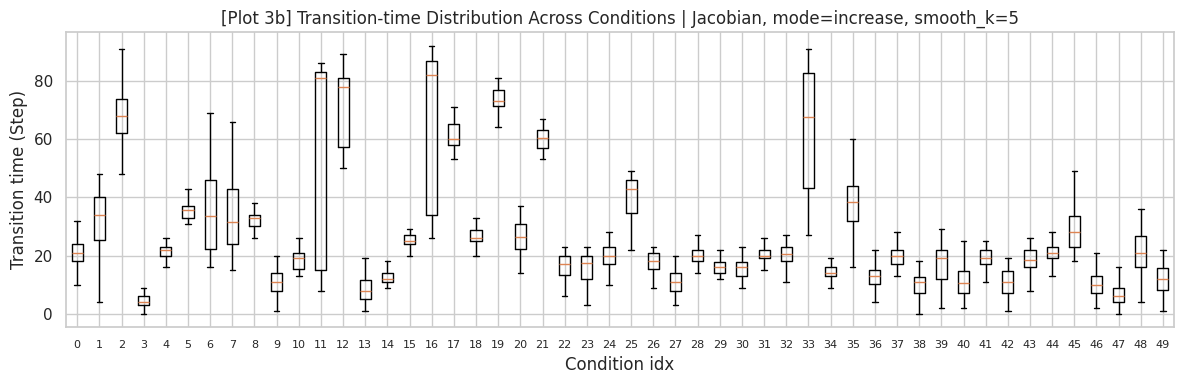

In [23]:
plot_3_distribution_across_conditions(dfs, metric_col="Jacobian", mode="increase", smooth_k=5)


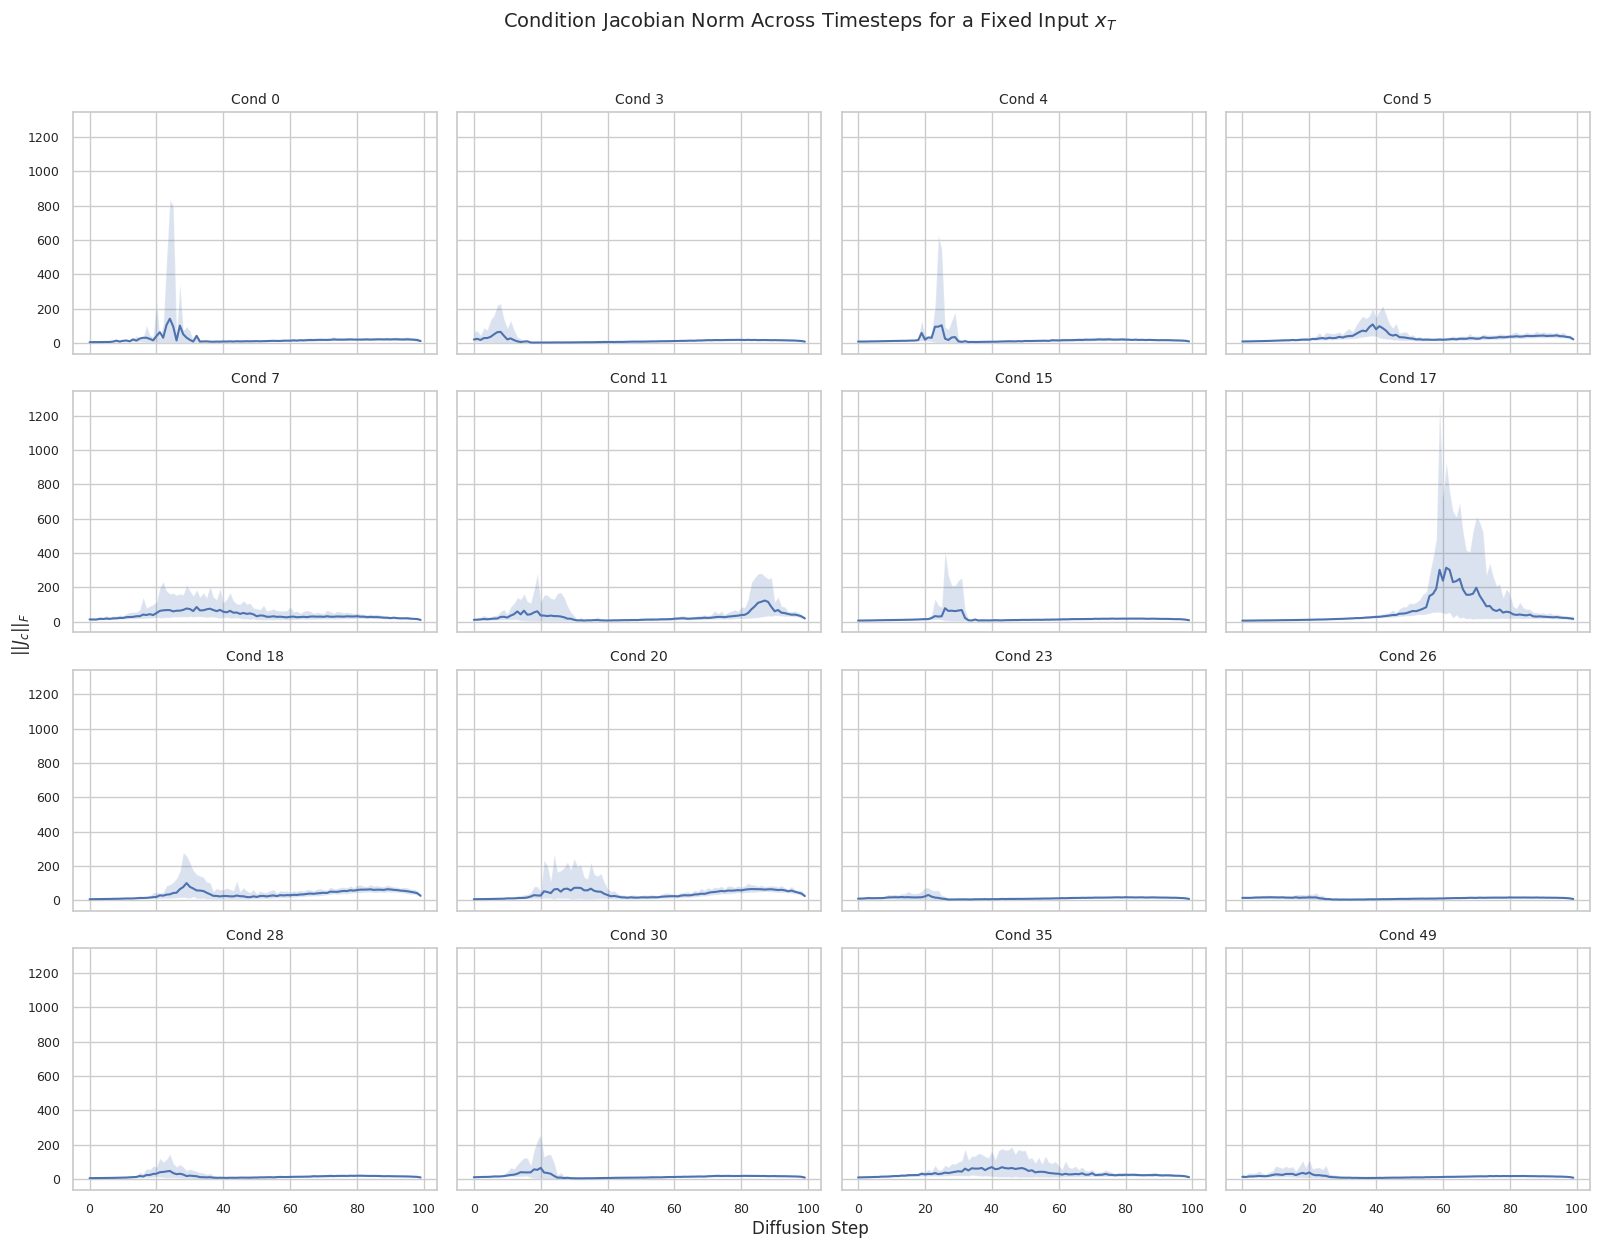

In [ ]:
# ============================================================
# Plot Additional) Specialized Small Multiples (4x4)
# ============================================================
selected_conds = [0, 3, 4, 5, 7, 11, 15, 17, 18, 20, 23, 26, 28, 30, 35, 49]
dfs_subset = {k: dfs[k] for k in selected_conds if k in dfs}

def plot_2_custom_subset_4x4(dfs_sub, metric_col="Diff",
                             time_col="Step", seed_col="Sample_Idx",
                             q=(0.05, 0.95)):
    conds = sorted(dfs_sub.keys())
    nrows, ncols = 4, 4
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.0*ncols, 3.0*nrows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    for ax_i, ax in enumerate(axes):
        if ax_i >= len(conds):
            ax.axis("off")
            continue
        c = conds[ax_i]
        # Use existing utility from previous cells
        steps, seeds, X = df_to_matrix(dfs_sub[c], metric_col, time_col, seed_col)
        mu, lo, hi, _ = quantile_band(X, qs=q)
        
        ax.fill_between(steps, lo, hi, alpha=0.2)
        ax.plot(steps, mu, linewidth=1.5)
        ax.set_title(f"Cond {c}", fontsize=10)
        ax.tick_params(labelsize=9)
        # ax.set_ylim(0, 200) # Optional

    # Global labels
    # x_label: Diffusion Step
    fig.text(0.5, 0.0, 'Diffusion Step', ha='center', fontsize=12)
    
    # y_label: $||J_c||_F$
    fig.text(0.0, 0.5, r'$||J_c||_F$', va='center', rotation='vertical', fontsize=12)
    
    # Title
    fig.suptitle(r"Condition Jacobian Norm Across Timesteps for a Fixed Input $x_T$", y=1.02, fontsize=14)
    
    fig.tight_layout()
    plt.show()

# Ensure metric_col is defined or default to Jacobian
if 'metric_col' not in locals():
    metric_col = "Jacobian"

plot_2_custom_subset_4x4(dfs_subset, metric_col=metric_col)


In [ ]:
# --- Added by Agent ---
# Compute time of MAXIMUM value (argmax_t x[t])
time_col = 'Step'
def compute_max_value_time_per_seed(X, steps, smooth_k=5):
    # Finds the timestep t where x[t] is maximized.
    S, T = X.shape
    pos = np.zeros(S, dtype=int)

    for i in range(S):
        y = X[i]
        if np.any(np.isnan(y)):
            y = pd.Series(y).interpolate(limit_direction="both").to_numpy()

        y = smooth_1d(y, k=smooth_k)
        
        # argmax of the value itself
        pos[i] = int(np.argmax(y))

    tau_steps = steps[pos]
    return tau_steps, pos

def plot_3b_max_value_distribution(dfs, metric_col="Diff",
                                   time_col="Step", seed_col="Sample_Idx",
                                   smooth_k=5, show_fliers=False):
    conds = sorted(dfs.keys())
    tau_all = []

    for c in conds:
        df = dfs[c]
        steps, seeds, X = df_to_matrix(df, metric_col=metric_col, time_col=time_col, seed_col=seed_col)
        tau_steps, _ = compute_max_value_time_per_seed(X, steps, smooth_k=smooth_k)
        tau_all.append(tau_steps)

    plt.figure(figsize=(12, 4))

    # Add grey band for 70% concentration (15th to 85th percentile)
    all_tau = np.concatenate(tau_all)
    low = np.percentile(all_tau, 15)
    high = np.percentile(all_tau, 85)
    plt.axhspan(low, high, color='gray', alpha=0.3, label='70% concentration')

    plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)
    plt.title(r"Distribution of Peak Diffusion Steps for $\|J_c\|_F$ Across Prompts")
    plt.title(r"Distribution of Peak Diffusion Steps for $\\|J_c\\|_F$ Across Prompts")
    plt.ylabel(f"Time of Peak (Diffusion Steps)")
    plt.xticks(rotation=0, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Use the subset of conditions defined previously
selected_conds = [x for x in range(50)]
dfs_subset = {c: dfs[c] for c in selected_conds if c in dfs}

print(f"Plotting max-value-time distribution for {len(dfs_subset)} conditions...")
plot_3b_max_value_distribution(dfs_subset, metric_col=metric_col, time_col=time_col, seed_col=seed_col, smooth_k = 1)


Plotting max-value-time distribution for 50 conditions...


/tmp/ipykernel_793769/69207709.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tau_all, labels=conds, showfliers=show_fliers)


ValueError: 
Distribution of Peak Diffusion Steps for $\\|J_c\\|_F$ Across Prompts
                                         ^
ParseException: Expected end of text, found '$'  (at char 41), (line:1, col:42)

Error in callback <function _draw_all_if_interactive at 0x719670b63ba0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
Distribution of Peak Diffusion Steps for $\\|J_c\\|_F$ Across Prompts
                                         ^
ParseException: Expected end of text, found '$'  (at char 41), (line:1, col:42)

ValueError: 
Distribution of Peak Diffusion Steps for $\\|J_c\\|_F$ Across Prompts
                                         ^
ParseException: Expected end of text, found '$'  (at char 41), (line:1, col:42)

<Figure size 1200x400 with 1 Axes>